In [1]:
import os
import time
import numpy as np

import torch
import torchvision
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

2025-12-12 16:16:28.246313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-12 16:16:28.403723: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-12 16:16:28.458230: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-12 16:16:31.191465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [2]:


# Verify it works (Should print nothing or just the version)
print(f" TensorFlow Loaded. Version: {tf.__version__}")




os.environ["CUDA_VISIBLE_DEVICES"] = "26" 


print(f"Locked to GPU {os.environ['CUDA_VISIBLE_DEVICES']}")

print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")




 TensorFlow Loaded. Version: 2.10.0
Locked to GPU 26
Num GPUs Available: 1


In [3]:
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
#For progress bar - we use tqdm
#https://tqdm.github.io
from tqdm import tqdm
import tensorflow as tf
import cv2


In [4]:
import tensorflow_addons as tfa

In [5]:
#We setup the i/p and o/p directories
input_directory = "./data"
classes = ['Glioma','Meningioma','Pituitary tumor']
output_directory = './augmented_images/'

image_size = (128,128)
random_seed = 42

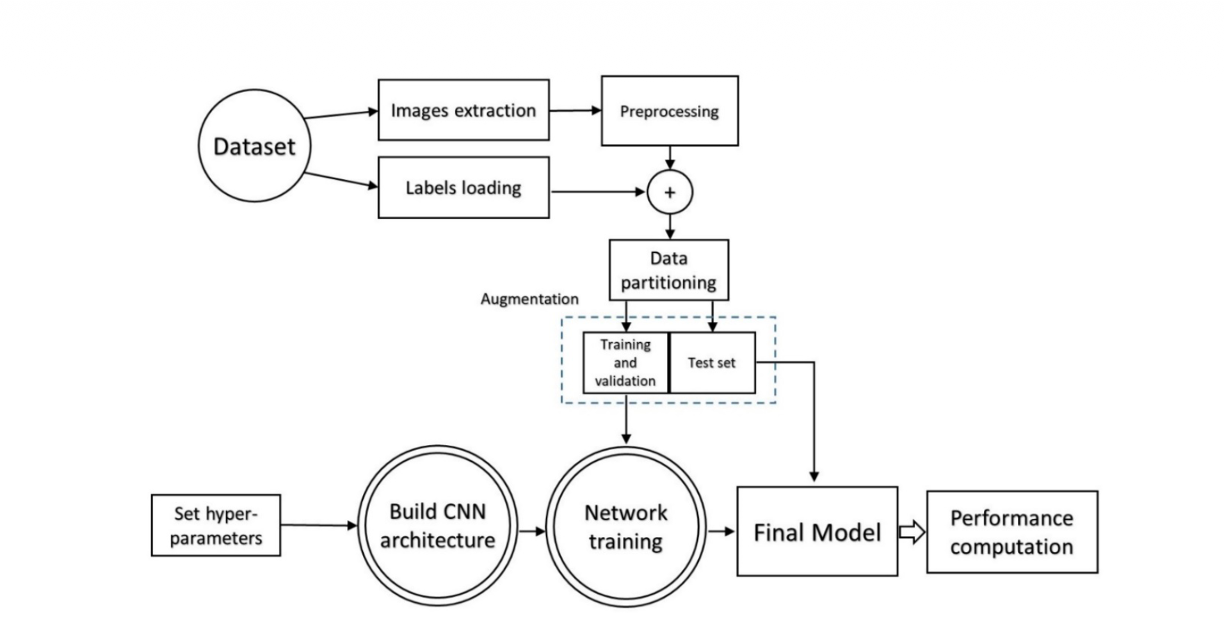

In [6]:
from PIL import Image
def flip_vertical(img):
    return cv2.flip(img,0)

def flip_horizontal(img):
    return cv2.flip(img,1)

def rotate_45(img):
    (h,w) = img.shape
    center = (w//2,h//2)
    rotation = cv2.getRotationMatrix2D(center,45,1)
    border = (0,0,0) if len(img.shape)==3 else 0
    return cv2.warpAffine(img, rotation, (w,h), borderValue=border)

def salt_noise(img, prob=0.02):
    noisy = np.copy(img)
    #np.ceil - round up, np.floor - round down..
    num_salt = np.ceil(prob *img.size)

    #Add noise randomly
    coords = [np.random.randint(0,i-1,int(num_salt)) for i in img.shape]
    noisy[coords[0],coords[1]] = 255
    return noisy
    
    

In [7]:
def get_images():
    all_paths = []
    all_labels=[]

    print("Here we scan the file path to find images")
    for label_idx,class_name in enumerate(classes):
        folder_path = os.path.join(input_directory, class_name)

        files = glob.glob(os.path.join(folder_path,'*'))
        #folder path = os.path.join(input_directory,classes
        #files = glob.glob(os.path.join(folder_path,'*))'
        clean_files = [f for f in files if 'mask' not in f.lower()]
        #clean_files = [f for f in files if 'xyz' not in f.lower()]
        for f in clean_files:
            all_paths.append(f)
            all_labels.append(label_idx)

    train_paths, test_paths, train_y, test_y  = train_test_split(
    all_paths, all_labels, test_size = 0.32, stratify=all_labels, random_state = random_seed
    )

    print(f"Augmentation Framework Ready - Lets Begin!: {len(train_paths)} Training Items, {len(test_paths)}Testing Items.")
    return train_paths, test_paths, train_y, test_y

In [8]:
def process_dataset(path_list,label_list,mode='train'):
    save_dir = os.path.join(output_directory, mode)

    print(f"Training and Testing has begun - will save in the {output_directory}")

    for i in tqdm(range(len(path_list))):
        img_path = path_list[i]
        label_idx = label_list[i]
        class_name = classes[label_idx]

        class_save_dir = os.path.join(save_dir,class_name)
        os.makedirs(class_save_dir,exist_ok= True)

        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size , interpolation=cv2.INTER_AREA)
            base_name = f"{mode}_{i:05d}"

            cv2.imwrite(os.path.join(class_save_dir, f"{base_name}_orig.png"),img)

            if mode == 'train':
                cv2.imwrite(os.path.join(class_save_dir,f"{base_name}_flipV.png"),flip_vertical(img))
                cv2.imwrite(os.path.join(class_save_dir,f"{base_name}_flipH.png"),flip_horizontal(img))
                cv2.imwrite(os.path.join(class_save_dir,f"{base_name}_salt.png"),salt_noise(img))
                cv2.imwrite(os.path.join(class_save_dir,f"{base_name}_rot45.png"),rotate_45(img))

        except Exception as e:
            print(f"Skipping bad files: {img_path} - {e}")

In [9]:
#Executing the functions made above
#Getting the list
train_files,test_files,train_labels,test_labels = get_images()
process_dataset(train_files,train_labels,mode='train')
process_dataset(test_files,test_labels,mode='test')

print("All Images processed")


Here we scan the file path to find images
Augmentation Framework Ready - Lets Begin!: 632 Training Items, 298Testing Items.
Training and Testing has begun - will save in the ./augmented_images/


100%|█████████████████████████████████████████████████████████████████████████████████| 632/632 [00:55<00:00, 11.44it/s]


Training and Testing has begun - will save in the ./augmented_images/


100%|█████████████████████████████████████████████████████████████████████████████████| 298/298 [00:08<00:00, 34.41it/s]

All Images processed


In [10]:
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

In [11]:
#Augmented images dataset is now our input dataset for deep learning
output_directory = './augmented_images/'
train_dir =os.path.join(output_directory,'train')
test_dir =os.path.join(output_directory,'test')

image_size = (128,128)
batch_size = 32
random_seed = 42
#Below images contain the tensorflow libraries documentation screeshot - so many parameters!

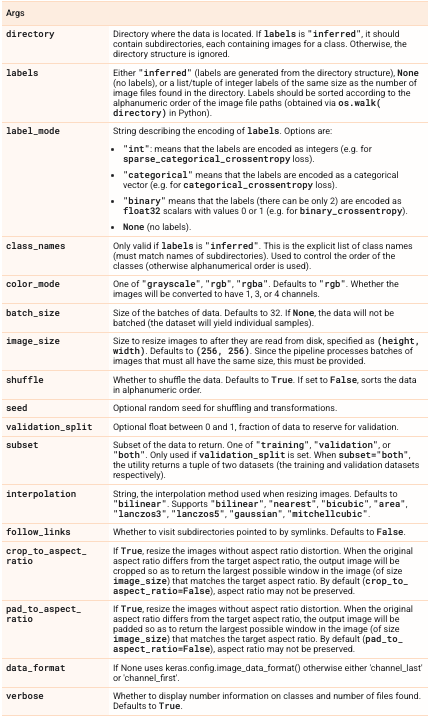

In [12]:
print(f"\nWe load the train dataset from: {os.path.abspath(train_dir)}")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'grayscale',
    batch_size = batch_size,
    image_size = image_size,
    shuffle=True,
    seed = random_seed
)

#Loading Test Data
print(f"\nWe load the test dataset from: {os.path.abspath(test_dir)}")
test_full_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    color_mode = 'grayscale',
    batch_size = batch_size,
    image_size = image_size,
    seed = random_seed,
    shuffle = False,
)

#Loading Validation set
#We keep 32% for testing - as per paper
val_batches = int(len(test_full_ds)*0.5)
val_ds = test_full_ds.take(val_batches)
test_ds = test_full_ds.skip(val_batches)
AUTOTUNE = tf.data.AUTOTUNE
'''Now we keep everything ready - trained images, the validation set and test set 
- then we just need to run the DL model a done by the authors in the paper and we are done..
Keeping Autotune on - to keep parameter tuning on auto'''

train_ds = train_ds.prefetch(buffer_size =AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print(f"Pipeline is now ready for the DL model implementation")
print(f"\nTraining batch size:{len(train_ds)}")
print(f"\nTesting batch size:{len(test_ds)}")
print(f"\nValidation batch size:{len(val_ds)}")




We load the train dataset from: /home/stu9/s7/ss2401/AI_TERM_PROJECT/augmented_images/train
Found 3160 files belonging to 3 classes.


2025-12-12 16:17:47.048791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-12 16:17:48.451772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13364 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:b1:00.0, compute capability: 8.6



We load the test dataset from: /home/stu9/s7/ss2401/AI_TERM_PROJECT/augmented_images/test
Found 298 files belonging to 3 classes.
Pipeline is now ready for the DL model implementation

Training batch size:99

Testing batch size:5

Validation batch size:5


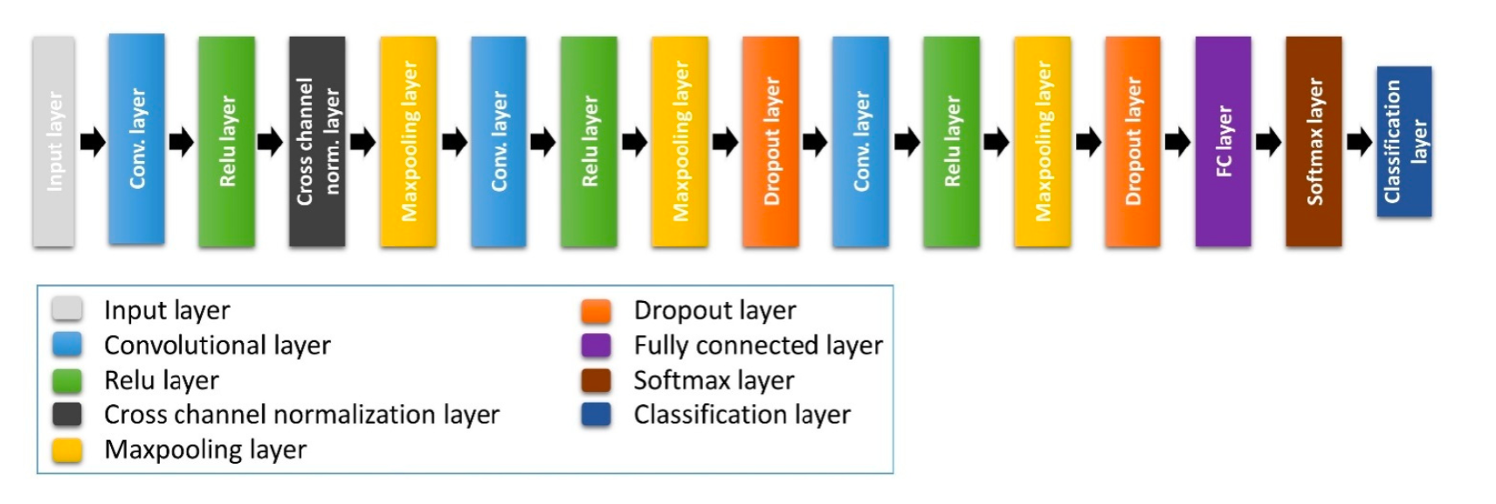

In [13]:
#Now we get to the good stuff - replicating papers DL model
def build_paper_nn(input_shape,num_classes):
    #In our case - input shape - image shape - 128*128 and num_classes = 3 (Meningioma, Glioma, Pituitary)
    model = models.Sequential(name="Sultan_et_al_CNN")
    
    #forming the model sequqnce - as per the image above- this model was used by the authors in the paper
    
    model.add(layers.Input(shape = input_shape))
    #Normalizing the pixel value (1,256) = (0,1) - by dividing the pixel values by 255
    
    model.add(layers.Rescaling(1./255))
    
    #Conv layer -for feature extraction
    model.add(layers.Conv2D(filters=64,kernel_size=(10,10),strides=1,padding='valid',name='conv1'))
    
    #Adding RELU Layer
    model.add(layers.ReLU(name='relu1'))
    
    #Performing cross channel normalization
    model.add(layers.Lambda(
        lambda x: tf.nn.local_response_normalization(x,depth_radius=2, bias=1.0, alpha=1.0, beta=0.5),
        name='lrn1'
    ))
    
    #Using max pool layer
    model.add(layers.MaxPool2D(pool_size=(2,2),strides=2,name='maxpool1'))
    
    #Block 2 - feature extraction
    #This time we increase the padding
    model.add(layers.ZeroPadding2D(padding=(2,2),name='pad2'))
    
    model.add(layers.Conv2D(128,(3,3),strides=1,padding='valid',name='conv2'))
    
    model.add(layers.ReLU(name='relu2'))
    
    model.add(layers.MaxPool2D((2,2),strides=2,name='maxpool2'))
    
    model.add(layers.Dropout(0.1,name='drop1'))
    
    
    
    model.add(layers.ZeroPadding2D(padding=(2,2),name='pad3'))
              
    model.add(layers.Conv2D(128,(2,2),strides=1,padding='valid',name='conv3'))
    
    model.add(layers.ReLU(name='relu3'))
    
    model.add(layers.MaxPool2D((2,2),strides=2,name='maxpool3'))
              
    model.add(layers.Dropout(0.2,name='drop2'))
    
    #Classifier phase = 2D to 1D array conversion - softmax will come intp play
    model.add(layers.Flatten(name='flat'))

    #fully connected layers - connects every feature to every class
    model.add(layers.Dense(units = num_classes,name='fc'))

    #Softmax layer
    model.add(layers.Activation('softmax',dtype='float32',name='softmax'))

    return model


#Building the model
baseline_model= build_paper_nn(input_shape=(128,128,1),num_classes=3)

optimizer = optimizers.SGD(learning_rate=0.01,momentum=0.9)

baseline_model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

baseline_model.summary()         

Model: "Sultan_et_al_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 1)       0         
                                                                 
 conv1 (Conv2D)              (None, 119, 119, 64)      6464      
                                                                 
 relu1 (ReLU)                (None, 119, 119, 64)      0         
                                                                 
 lrn1 (Lambda)               (None, 119, 119, 64)      0         
                                                                 
 maxpool1 (MaxPooling2D)     (None, 59, 59, 64)        0         
                                                                 
 pad2 (ZeroPadding2D)        (None, 63, 63, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 61, 61, 128)  

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

# STANDARD BASELINE - FOLLOWING AUTHORS STEPS

In [15]:
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


#1. CALCULATING CLASS WEIGHTS
# We need to know which class index corresponds to which name
# Usually: 0=Glioma, 1=Meningioma, 2=Pituitary
# But let's be safe and calculate based on the actual training data labels.


#2. INITIALIZING & COMPILING
# Resetting the model to ensure no "warm start" from the previous run
baseline_model = build_paper_nn(input_shape=(128,128,1), num_classes=3)

# Optimizer: SGD (Standard Gradient Descent)
optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9)

baseline_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#3. CALLBACKS (Where the model is stored) - Very important
# We use a NEW filename so we don't overwrite your optimized run
checkpoint_path = 'sultan_paper_baseline.keras' 

checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

In [16]:
# 4. TRAIN (No Weights)
print(f"\n Starting Exact Paper Replication (SGD, No Class Weights)...")
print(f" Best model will be saved to: {checkpoint_path}")

history = baseline_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stop]
)

print("\n Baseline Training Complete.")


 Starting Exact Paper Replication (SGD, No Class Weights)...
 Best model will be saved to: sultan_paper_baseline.keras
Epoch 1/100


2025-12-12 16:17:51.924608: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-12-12 16:17:53.089116: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-12-12 16:17:53.091592: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-12-12 16:17:53.091660: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-12-12 16:17:53.094226: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-12-12 16:17:53.094452: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-12-12 16:18:00.688228: I tensorflow/stream_executor/cuda/c

99/99 [==============================] - ETA: 0s - loss: 0.8456 - accuracy: 0.6329
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to sultan_paper_baseline.keras
99/99 [==============================] - 24s 121ms/step - loss: 0.8456 - accuracy: 0.6329 - val_loss: 0.4852 - val_accuracy: 1.0000
Epoch 2/100
99/99 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.6646
Epoch 2: val_accuracy did not improve from 1.00000
99/99 [==============================] - 10s 99ms/step - loss: 0.7675 - accuracy: 0.6646 - val_loss: 0.5401 - val_accuracy: 1.0000
Epoch 3/100
99/99 [==============================] - ETA: 0s - loss: 0.7179 - accuracy: 0.6747
Epoch 3: val_accuracy did not improve from 1.00000
99/99 [==============================] - 10s 99ms/step - loss: 0.7179 - accuracy: 0.6747 - val_loss: 0.4764 - val_accuracy: 0.9563
Epoch 4/100
99/99 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.6864
Epoch 4: val_accuracy did not improve f


 Generating Predictions for Table 3 Metrics...

 REPLICATION RESULTS (Study 1):
Tumor Type      | Precision  | Sensitivity | Specificity | Accuracy  
----------------------------------------------------------------------
Glioma          | 0.2754     | 1.0000      | 0.0000      | 0.2754
Meningioma      | 0.0000     | 0.0000      | 1.0000      | 0.3913
Pituitary tumor | 0.0000     | 0.0000      | 1.0000      | 0.8841
----------------------------------------------------------------------
 Overall Accuracy: 27.54%


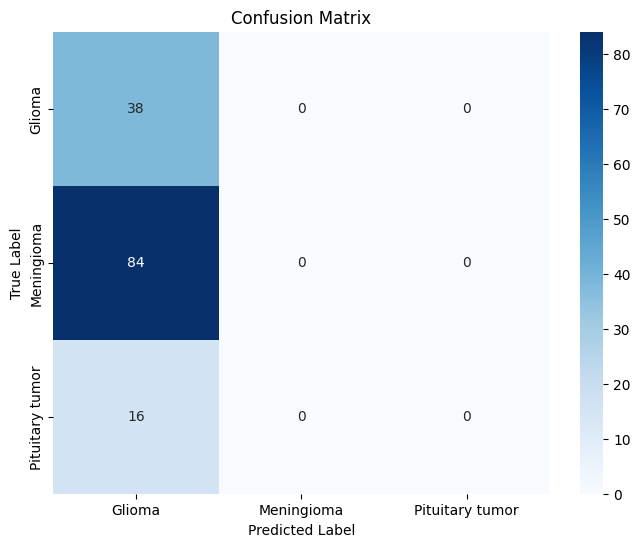

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def get_paper_metrics(model, dataset, classes):
    print("\n Generating Predictions for Table 3 Metrics...")
    
    # 1. Get Predictions
    y_true = []
    y_pred = []
    
    # Loop through batches so we don't load everything into RAM at once
    for img_batch, label_batch in dataset:
        # Predict
        preds = model.predict(img_batch, verbose=0)
        # Convert One-Hot to Index (e.g., [0, 1, 0] -> 1)
        y_true.extend(np.argmax(label_batch.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        
    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # 3. Per-Class Metrics (Precision, Sensitivity, Specificity)
    # Formulae based on Equation 5 and Table 3 description
    print("\n REPLICATION RESULTS (Study 1):")
    print(f"{'Tumor Type':<15} | {'Precision':<10} | {'Sensitivity':<11} | {'Specificity':<11} | {'Accuracy':<10}")
    print("-" * 70)
    
    total_tp = 0
    total_samples = cm.sum()
    
    for i, class_name in enumerate(classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        
        total_tp += tp
        
        # Calculations
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0 # (Recall)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / total_samples
        
        print(f"{class_name:<15} | {precision:.4f}     | {sensitivity:.4f}      | {specificity:.4f}      | {accuracy:.4f}")
    
    print("-" * 70)
    overall_acc = total_tp / total_samples
    print(f" Overall Accuracy: {overall_acc*100:.2f}%")
    
    # 4. Plot Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Run it
get_paper_metrics(baseline_model, test_ds, classes)

# OPTIMIZING BASELINE TO BEAT WITH OUR GAN APPROACH

In [19]:
#2. CALCULATE CLASS WEIGHTS
print("Calculating Class Weights (This may take a moment)...")
y_train_indices = []
# Loop through training data to count classes
for images, labels in train_ds.unbatch():
    y_train_indices.append(np.argmax(labels.numpy()))

y_train_indices = np.array(y_train_indices)

# Compute "Balanced" weights
class_weights_calc = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)
# Map indices to weights
class_weights_dict = dict(enumerate(class_weights_calc))
print(f"Class Weights Ready: {class_weights_dict}")

#3. SETUP MODEL & OPTIMIZER
# Initialize fresh model
baseline_model = build_paper_nn(input_shape=(128,128,1), num_classes=3)

# Use ADAM (The "Smart" Optimizer)
optimizer = optimizers.Adam(learning_rate=0.0001)

baseline_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. CALLBACKS
# Saving to a NEW filename so we don't overwrite previous experiments
checkpoint_path = 'sultan_optimized_best.keras'

checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

# Reduce LR is helpful for Adam to "settle" into the best spot
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6,
    verbose=1
)

# 5. RUN TRAINING
print(f"\nStarting OPTIMIZED Training (Adam + Class Weights)...")


history = baseline_model.fit(
    train_ds,
    epochs=60,
    validation_data=val_ds,
    class_weight=class_weights_dict,  # <--- The secret sauce
    callbacks=[checkpoint, early_stop, reduce_lr]
)

print("\nOptimized Training Complete.")

Calculating Class Weights (This may take a moment)...
Class Weights Ready: {0: 0.5015873015873016, 1: 1.1902071563088512, 2: 6.019047619047619}

Starting OPTIMIZED Training (Adam + Class Weights)...
Epoch 1/60
99/99 [==============================] - ETA: 0s - loss: 0.9829 - accuracy: 0.3949
Epoch 1: val_accuracy improved from -inf to 0.45000, saving model to sultan_optimized_best.keras
99/99 [==============================] - 10s 100ms/step - loss: 0.9829 - accuracy: 0.3949 - val_loss: 1.0879 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 2/60
99/99 [==============================] - ETA: 0s - loss: 0.8187 - accuracy: 0.5082
Epoch 2: val_accuracy improved from 0.45000 to 0.54375, saving model to sultan_optimized_best.keras
99/99 [==============================] - 10s 99ms/step - loss: 0.8187 - accuracy: 0.5082 - val_loss: 0.9301 - val_accuracy: 0.5437 - lr: 1.0000e-04
Epoch 3/60
99/99 [==============================] - ETA: 0s - loss: 0.7603 - accuracy: 0.5684
Epoch 3: val_accuracy did

 Generating Predictions (Vectorized Mode)...
5/5 [==============================] - 0s 29ms/step

 OPTIMIZED BASELINE RESULTS:
Tumor Type      | Precision  | Sensitivity | Specificity | Accuracy  
---------------------------------------------------------------------------
Glioma          | 0.6122     | 0.7895      | 0.8100      | 0.8043
Meningioma      | 0.9155     | 0.7738      | 0.8889      | 0.8188
Pituitary tumor | 0.8889     | 1.0000      | 0.9836      | 0.9855
---------------------------------------------------------------------------
 Overall Accuracy: 80.43%


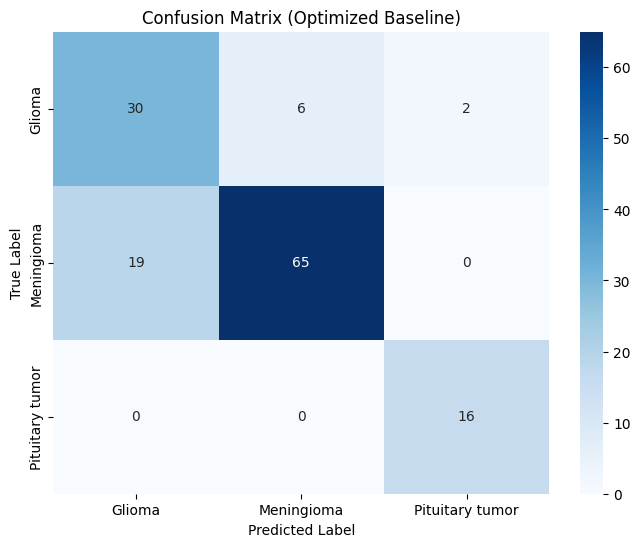

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_clean(model, dataset, classes):
    print(" Generating Predictions (Vectorized Mode)...")
    
    # 1. Get ALL predictions in one pass (Faster, No Warnings)
    # model.predict() handles the batches automatically
    predictions = model.predict(dataset, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    
    # 2. Extract True Labels from the dataset
    y_true = np.concatenate([y for x, y in dataset], axis=0)
    y_true = np.argmax(y_true, axis=1)
    
    # 3. Generate Metrics
    cm = confusion_matrix(y_true, y_pred)
    
    print("\n OPTIMIZED BASELINE RESULTS:")
    print(f"{'Tumor Type':<15} | {'Precision':<10} | {'Sensitivity':<11} | {'Specificity':<11} | {'Accuracy':<10}")
    print("-" * 75)
    
    total_samples = cm.sum()
    total_correct = 0
    
    for i, class_name in enumerate(classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        total_correct += tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / total_samples
        
        print(f"{class_name:<15} | {precision:.4f}     | {sensitivity:.4f}      | {specificity:.4f}      | {accuracy:.4f}")

    print("-" * 75)
    print(f" Overall Accuracy: {(total_correct/total_samples)*100:.2f}%")
    
    # 4. Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Optimized Baseline)')
    plt.show()

# Run the fixed version
evaluate_model_clean(baseline_model, test_ds, classes)

# NOW WE WORK ON THE WGAN MODEL - TO BEAT THE BASELINE RESULTS

In [21]:
import os
import glob
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np


# 1. CONFIGURATION CLASS

class Config:
    # Paths
    dataroot = "./data"                   # Input folder containing your class subfolders
    output_root = "./WGAN_Results"        # Root folder for all outputs
    checkpoint_dir = "./checkpoints"      # NEW: Folder to save model weights
    
    # Generation Settings
    images_to_generate = 5000             # How many new images to create PER CLASS -here we do something amazing - 5000 images per class
    
    # WGAN Hyperparameters
    workers = 2
    batch_size = 32
    image_size = 64      # All images resized to 64x64 for the GAN
    nc = 3               # Number of channels (3 for RGB)
    nz = 100             # Size of latent vector (noise input)
    ngf = 64             # Size of feature maps in generator
    ndf = 64             # Size of feature maps in critic
    num_epochs = 500     # Training epochs per class
    lr = 0.00005         # Learning rate (Low LR is standard for WGAN)
    clip_value = 0.01    # Weight clipping range (Crucial for WGAN stability)
    n_critic = 5         # Train critic 5 times for every 1 generator step
    manual_seed = 999
    
    # Monitoring
    save_interval = 50   #Save model and sample images every 50 epochs
    
    # Device Handling
    device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

print(f"Running on Device: {Config.device}")

# Set random seed for reproducibility
random.seed(Config.manual_seed)
torch.manual_seed(Config.manual_seed)
os.makedirs(Config.output_root, exist_ok=True)
os.makedirs(Config.checkpoint_dir, exist_ok=True)


# 2. CUSTOM DATASET WRAPPER

class SingleClassDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, 0 


# 3. WGAN ARCHITECTURE


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z (noise) -> Upsample to 4x4
            nn.ConvTranspose2d(Config.nz, Config.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(Config.ngf * 8),
            nn.ReLU(True),
            # Upsample to 8x8
            nn.ConvTranspose2d(Config.ngf * 8, Config.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ngf * 4),
            nn.ReLU(True),
            # Upsample to 16x16
            nn.ConvTranspose2d(Config.ngf * 4, Config.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ngf * 2),
            nn.ReLU(True),
            # Upsample to 32x32
            nn.ConvTranspose2d(Config.ngf * 2, Config.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ngf),
            nn.ReLU(True),
            # Upsample to 64x64 (Final Output)
            nn.ConvTranspose2d(Config.ngf, Config.nc, 4, 2, 1, bias=False),
            nn.Tanh() # Squashes output to [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            # Input 64x64 -> Downsample to 32x32
            nn.Conv2d(Config.nc, Config.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Downsample to 16x16
            nn.Conv2d(Config.ndf, Config.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Downsample to 8x8
            nn.Conv2d(Config.ndf * 2, Config.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Downsample to 4x4
            nn.Conv2d(Config.ndf * 4, Config.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Config.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Output: 1x1 scalar
            nn.Conv2d(Config.ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)


# 4. MAIN EXECUTION LOOP


if not os.path.exists(Config.dataroot):
    raise FileNotFoundError(f"Data directory '{Config.dataroot}' not found!")

classes = [d for d in os.listdir(Config.dataroot) 
           if os.path.isdir(os.path.join(Config.dataroot, d)) 
           and not d.startswith('.')]

print(f"Detected Classes: {classes}")

for class_name in classes:
    print(f"\n{'='*50}")
    print(f"PROCESSING CLASS: {class_name}")
    print(f"{'='*50}")

    # Setup Directories for this class
    class_save_dir = os.path.join(Config.output_root, class_name)
    class_ckpt_dir = os.path.join(Config.checkpoint_dir, class_name)
    os.makedirs(class_save_dir, exist_ok=True)
    os.makedirs(class_ckpt_dir, exist_ok=True)

    # Step A: Filter Data 
    class_folder = os.path.join(Config.dataroot, class_name)
    all_files = glob.glob(os.path.join(class_folder, '*'))
    valid_files = [f for f in all_files 
                   if 'mask' not in f.lower() 
                   and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    if len(valid_files) == 0:
        print(f"Warning: No valid images found for {class_name}. Skipping.")
        continue

    dataset = SingleClassDataset(valid_files, transform=transforms.Compose([
        transforms.Resize(Config.image_size),
        transforms.CenterCrop(Config.image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))
    
    dataloader = DataLoader(dataset, batch_size=Config.batch_size, 
                            shuffle=True, num_workers=Config.workers)

    # Step B: Initialize Models
    netG = Generator().to(Config.device)
    netD = Critic().to(Config.device)
    netG.apply(weights_init)
    netD.apply(weights_init)

    optimizerD = optim.RMSprop(netD.parameters(), lr=Config.lr)
    optimizerG = optim.RMSprop(netG.parameters(), lr=Config.lr)
    
    # Fixed noise for monitoring progress (visual consistency)
    fixed_noise = torch.randn(64, Config.nz, 1, 1, device=Config.device)

    # Step C: Training Loop
    print(f"Starting WGAN Training for {class_name}...")
    
    for epoch in range(Config.num_epochs):
        for i, data in enumerate(dataloader, 0):
            
            # (1) Update Critic
            netD.zero_grad()
            real_cpu = data[0].to(Config.device)
            current_batch_size = real_cpu.size(0)
            
            output_real = netD(real_cpu).view(-1)
            
            noise = torch.randn(current_batch_size, Config.nz, 1, 1, device=Config.device)
            fake_imgs = netG(noise).detach()
            output_fake = netD(fake_imgs).view(-1)
            
            # WGAN Loss
            errD = -torch.mean(output_real) + torch.mean(output_fake)
            errD.backward()
            optimizerD.step()

            # Weight Clipping
            for p in netD.parameters():
                p.data.clamp_(-Config.clip_value, Config.clip_value)

            # (2) Update Generator
            if i % Config.n_critic == 0:
                netG.zero_grad()
                noise = torch.randn(current_batch_size, Config.nz, 1, 1, device=Config.device)
                fake_imgs = netG(noise)
                output = netD(fake_imgs).view(-1)
                
                errG = -torch.mean(output)
                errG.backward()
                optimizerG.step()
        
        # LOGGING & CHECKPOINTING
        if epoch % 10 == 0:
            print(f"  [Epoch {epoch}/{Config.num_epochs}] Loss D: {errD.item():.4f} | Loss G: {errG.item():.4f}")

        # Save Checkpoint & Progress Images every 'save_interval' epochs
        if (epoch + 1) % Config.save_interval == 0:
            # 1. Save Model Weights
            torch.save(netG.state_dict(), f"{class_ckpt_dir}/netG_epoch_{epoch+1}.pth")
            torch.save(netD.state_dict(), f"{class_ckpt_dir}/netD_epoch_{epoch+1}.pth")
            print(f"    -> Checkpoint saved at epoch {epoch+1}")

            # 2. Save Progress Image (Visual Inspection)
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            vutils.save_image(fake, f"{class_ckpt_dir}/progress_epoch_{epoch+1}.png", normalize=True)

    # Step D: Final Generation
    print(f"Generating {Config.images_to_generate} final images for {class_name}...")
    
    netG.eval()
    with torch.no_grad():
        for k in range(Config.images_to_generate):
            noise = torch.randn(1, Config.nz, 1, 1, device=Config.device)
            fake_img = netG(noise).detach().cpu()
            vutils.save_image(fake_img, f"{class_save_dir}/aug_{class_name}_{k}.png", normalize=True)
            
    # Save Final Model
    torch.save(netG.state_dict(), f"{class_ckpt_dir}/netG_final.pth")
    print(f"Completed {class_name}. Saved to: {class_save_dir}")

print("\n" + "="*50)
print("ALL CLASSES PROCESSED.")
print(f"Final Images: {Config.output_root}")
print(f"Checkpoints:  {Config.checkpoint_dir}")
print("="*50)

Running on Device: cuda:0
Detected Classes: ['Glioma', 'Pituitary tumor', 'Meningioma']

PROCESSING CLASS: Glioma
Starting WGAN Training for Glioma...
  [Epoch 0/500] Loss D: -0.0417 | Loss G: -0.0104
  [Epoch 10/500] Loss D: -0.3773 | Loss G: 0.2687
  [Epoch 20/500] Loss D: -0.8685 | Loss G: 0.4408
  [Epoch 30/500] Loss D: -0.8901 | Loss G: 0.5726
  [Epoch 40/500] Loss D: -1.2790 | Loss G: 0.6319
    -> Checkpoint saved at epoch 50
  [Epoch 50/500] Loss D: -1.3279 | Loss G: 0.6628
  [Epoch 60/500] Loss D: -1.3543 | Loss G: 0.6703
  [Epoch 70/500] Loss D: -1.3979 | Loss G: 0.6683
  [Epoch 80/500] Loss D: -1.3798 | Loss G: 0.6743
  [Epoch 90/500] Loss D: -1.3693 | Loss G: 0.6750
    -> Checkpoint saved at epoch 100
  [Epoch 100/500] Loss D: -1.4167 | Loss G: 0.6727
  [Epoch 110/500] Loss D: -1.3569 | Loss G: 0.6704
  [Epoch 120/500] Loss D: -1.4172 | Loss G: 0.6821
  [Epoch 130/500] Loss D: -1.4169 | Loss G: 0.6794
  [Epoch 140/500] Loss D: -1.4209 | Loss G: 0.6842
    -> Checkpoint sav

 Cleaning directories 

PROCESSING: Sultan Paper Baseline - With GAN Augmentation
-> Model Requirements detected: (128, 128) | Channels: 1
   -> Loading Data: Size=(128, 128), Color=grayscale
Found 1860 files belonging to 3 classes.
Using 1488 files for training.
Found 1860 files belonging to 3 classes.
Using 372 files for validation.
Found 15000 files belonging to 3 classes.
-> Fine-Tuning...
Epoch 1/10
516/516 [==============================] - 54s 99ms/step - loss: 0.8395 - accuracy: 0.6525
Epoch 2/10
516/516 [==============================] - 52s 98ms/step - loss: 0.3361 - accuracy: 0.8858
Epoch 3/10
516/516 [==============================] - 51s 97ms/step - loss: 0.2482 - accuracy: 0.9193
Epoch 4/10
516/516 [==============================] - 51s 97ms/step - loss: 0.2046 - accuracy: 0.9360
Epoch 5/10
516/516 [==============================] - 51s 97ms/step - loss: 0.1753 - accuracy: 0.9442
Epoch 6/10
516/516 [==============================] - 51s 97ms/step - loss: 0.1537 - accuracy

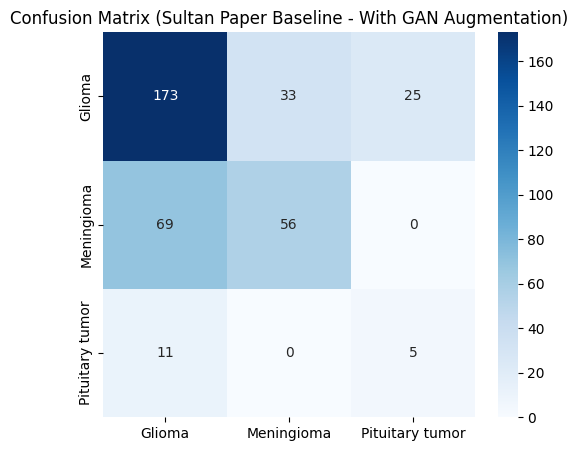


PROCESSING: Sultan Paper Optimized Baseline - With GAN Augmentation
-> Model Requirements detected: (128, 128) | Channels: 1
   -> Loading Data: Size=(128, 128), Color=grayscale
Found 1860 files belonging to 3 classes.
Using 1488 files for training.
Found 1860 files belonging to 3 classes.
Using 372 files for validation.
Found 15000 files belonging to 3 classes.
-> Fine-Tuning...
Epoch 1/10
516/516 [==============================] - 52s 98ms/step - loss: 0.3404 - accuracy: 0.8738
Epoch 2/10
516/516 [==============================] - 51s 97ms/step - loss: 0.1732 - accuracy: 0.9469
Epoch 3/10
516/516 [==============================] - 50s 96ms/step - loss: 0.1278 - accuracy: 0.9615
Epoch 4/10
516/516 [==============================] - 50s 96ms/step - loss: 0.1069 - accuracy: 0.9669
Epoch 5/10
516/516 [==============================] - 51s 98ms/step - loss: 0.0925 - accuracy: 0.9699
Epoch 6/10
516/516 [==============================] - 51s 98ms/step - loss: 0.0820 - accuracy: 0.9731
Epoc

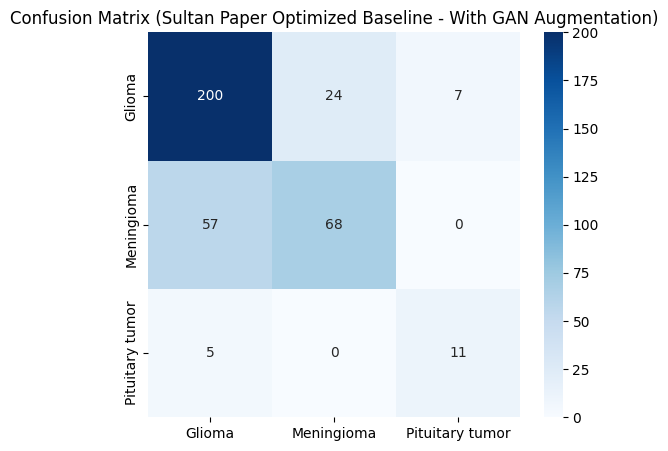

In [22]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix


# 1. CLEANUP UTILITY

def cleanup_hidden_files(root_dir):
    """
    Removes .ipynb_checkpoints folders that cause TensorFlow to crash.
    """
    for root, dirs, files in os.walk(root_dir):
        for d in dirs:
            if d == ".ipynb_checkpoints":
                full_path = os.path.join(root, d)
                print(f"Removing hidden folder: {full_path}")
                try:
                    shutil.rmtree(full_path)
                except Exception as e:
                    print(f"Warning: Could not remove {full_path}: {e}")

# Clean both directories immediately
print(" Cleaning directories ")
ORIGINAL_DATA_DIR = "./data"
WGAN_DATA_DIR = "./WGAN_Results"
cleanup_hidden_files(ORIGINAL_DATA_DIR)
cleanup_hidden_files(WGAN_DATA_DIR)


# 2. CONFIGURATION

# Now that folders are clean, we can rely on auto-detection or explicit lists
VALID_CLASSES = ['Glioma', 'Meningioma', 'Pituitary tumor']
SULTAN_PATH = "./sultan_paper_baseline.keras"
OPTIMIZED_PATH = "./sultan_optimized_best.keras"
BATCH_SIZE = 32


# 3. SMART DATA LOADER

def get_tailored_datasets(target_size, target_channels):
    """
    Creates datasets specifically resized and colored for the target model.
    """
    color_mode = "grayscale" if target_channels == 1 else "rgb"
    print(f"   -> Loading Data: Size={target_size}, Color={color_mode}")

    # A. Original Data (Split 80/20)
    train_ds = image_dataset_from_directory(
        ORIGINAL_DATA_DIR,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=target_size,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        color_mode=color_mode,
        class_names=VALID_CLASSES 
    )

    test_ds = image_dataset_from_directory(
        ORIGINAL_DATA_DIR,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=target_size,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        color_mode=color_mode,
        class_names=VALID_CLASSES
    )

    # B. WGAN Data (100% Training)
    wgan_ds = image_dataset_from_directory(
        WGAN_DATA_DIR,
        image_size=target_size,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        color_mode=color_mode,
        class_names=VALID_CLASSES,
        shuffle=True
    )

    # C. Combine for Training
    combined_train_ds = train_ds.concatenate(wgan_ds)
    combined_train_ds = combined_train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return combined_train_ds, test_ds


# 4. EVALUATION FUNCTION

def evaluate_model_clean(model, dataset, classes, model_name="Model"):
    print(f"\n Generating Predictions for {model_name}...")
    
    y_true = []
    y_pred = []
    
    # Iterate safely to prevent batch alignment issues
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n RESULTS FOR: {model_name.upper()}")
    print(f"{'Class':<15} | {'Precision':<10} | {'Sensitivity':<11} | {'Specificity':<11} | {'Accuracy':<10}")
    print("-" * 75)
    
    total_samples = cm.sum()
    total_correct = 0
    
    for i, class_name in enumerate(classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        total_correct += tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        accuracy = (tp + tn) / total_samples
        
        print(f"{class_name:<15} | {precision:.4f}     | {sensitivity:.4f}      | {specificity:.4f}      | {accuracy:.4f}")

    print("-" * 75)
    print(f" Overall Accuracy: {(total_correct/total_samples)*100:.2f}%")
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()


# 5. MAIN PROCESSING LOOP

def process_model(model_path, model_name):
    print(f"\n{'='*50}")
    print(f"PROCESSING: {model_name}")
    print(f"{'='*50}")

    # A. Load Model
    try:
        model = load_model(model_path)
    except Exception as e:
        print(f"Error loading {model_path}: {e}")
        return

    # B. Auto-Detect Input Requirements
    # Handle different shape formats safely
    if model.input_shape[0] is None:
        input_size = model.input_shape[1:3]
    else:
        input_size = model.input_shape[0:2]
        
    input_channels = model.input_shape[-1]
    
    print(f"-> Model Requirements detected: {input_size} | Channels: {input_channels}")

    # C. Get Data
    train_ds, test_ds = get_tailored_datasets(input_size, input_channels)

    # D. Fine-Tune
    print("-> Fine-Tuning...")
    # Low learning rate to avoid destroying pre-trained weights
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_ds, epochs=10, verbose=1)
    
    # E. Evaluate
    evaluate_model_clean(model, test_ds, VALID_CLASSES, model_name)

# Run Sultan
process_model(SULTAN_PATH, "Sultan Paper Baseline - With GAN Augmentation")

# Run Optimized
process_model(OPTIMIZED_PATH, "Sultan Paper Optimized Baseline - With GAN Augmentation")

# LOVELY - Project done - now plotting some useful plots for the posters to understand visually where have we improved

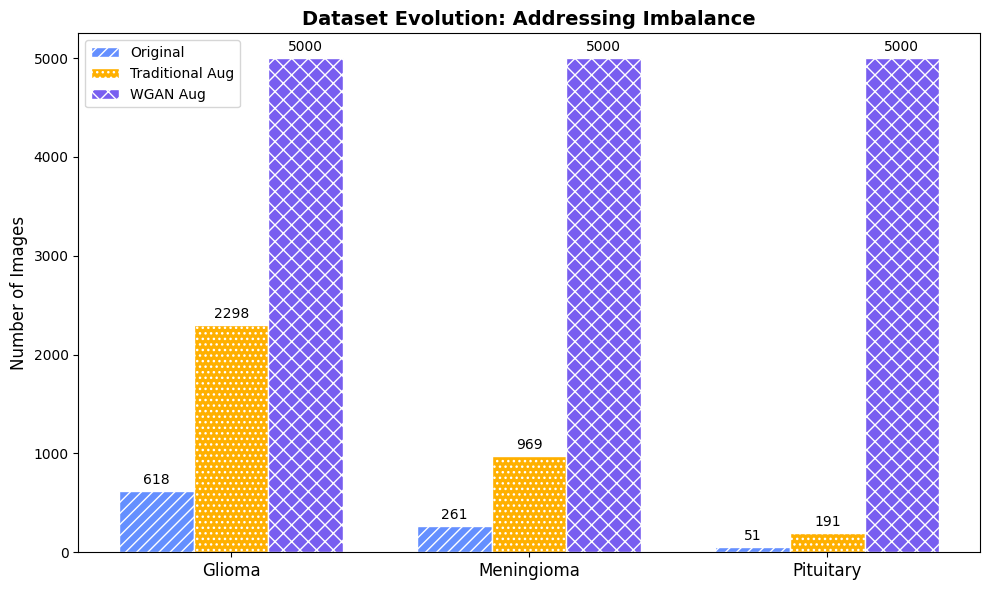

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 1. The Data
# These are the actual numbers you gave me
classes = ['Glioma', 'Meningioma', 'Pituitary']
original_counts = [618, 261, 51]           
traditional_counts = [2298, 969, 191]       
wgan_counts = [5000, 5000, 5000]            

# 2. Setup the Plot
x = np.arange(len(classes))
width = 0.25  # Making bars skinny so 3 fit side-by-side

# IBM Colorblind Safe Palette
# These colors are distinct for almost all forms of color blindness
c_orig = '#648FFF'   # Soft Blue
c_trad = '#FFB000'   # Gold/Yellow
c_wgan = '#785EF0'   # Indigo/Purple

fig, ax = plt.subplots(figsize=(10, 6))

# 3. Draw the Bars
# We add 'hatch' patterns so you can tell them apart without color too
# Original = Blue with Diagonal Stripes
rects1 = ax.bar(x - width, original_counts, width, label='Original', 
                color=c_orig, hatch='///', edgecolor='white')

# Traditional = Gold with Dots
rects2 = ax.bar(x, traditional_counts, width, label='Traditional Aug', 
                color=c_trad, hatch='...', edgecolor='white')

# WGAN = Purple with Crosses (The Winner)
rects3 = ax.bar(x + width, wgan_counts, width, label='WGAN Aug', 
                color=c_wgan, hatch='xx', edgecolor='white')

# 4. Make it Look Nice 
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Dataset Evolution: Addressing Imbalance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=12)
ax.legend() # Shows the key for colors/patterns

# Put the actual numbers on top of the bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

plt.tight_layout()
plt.show()

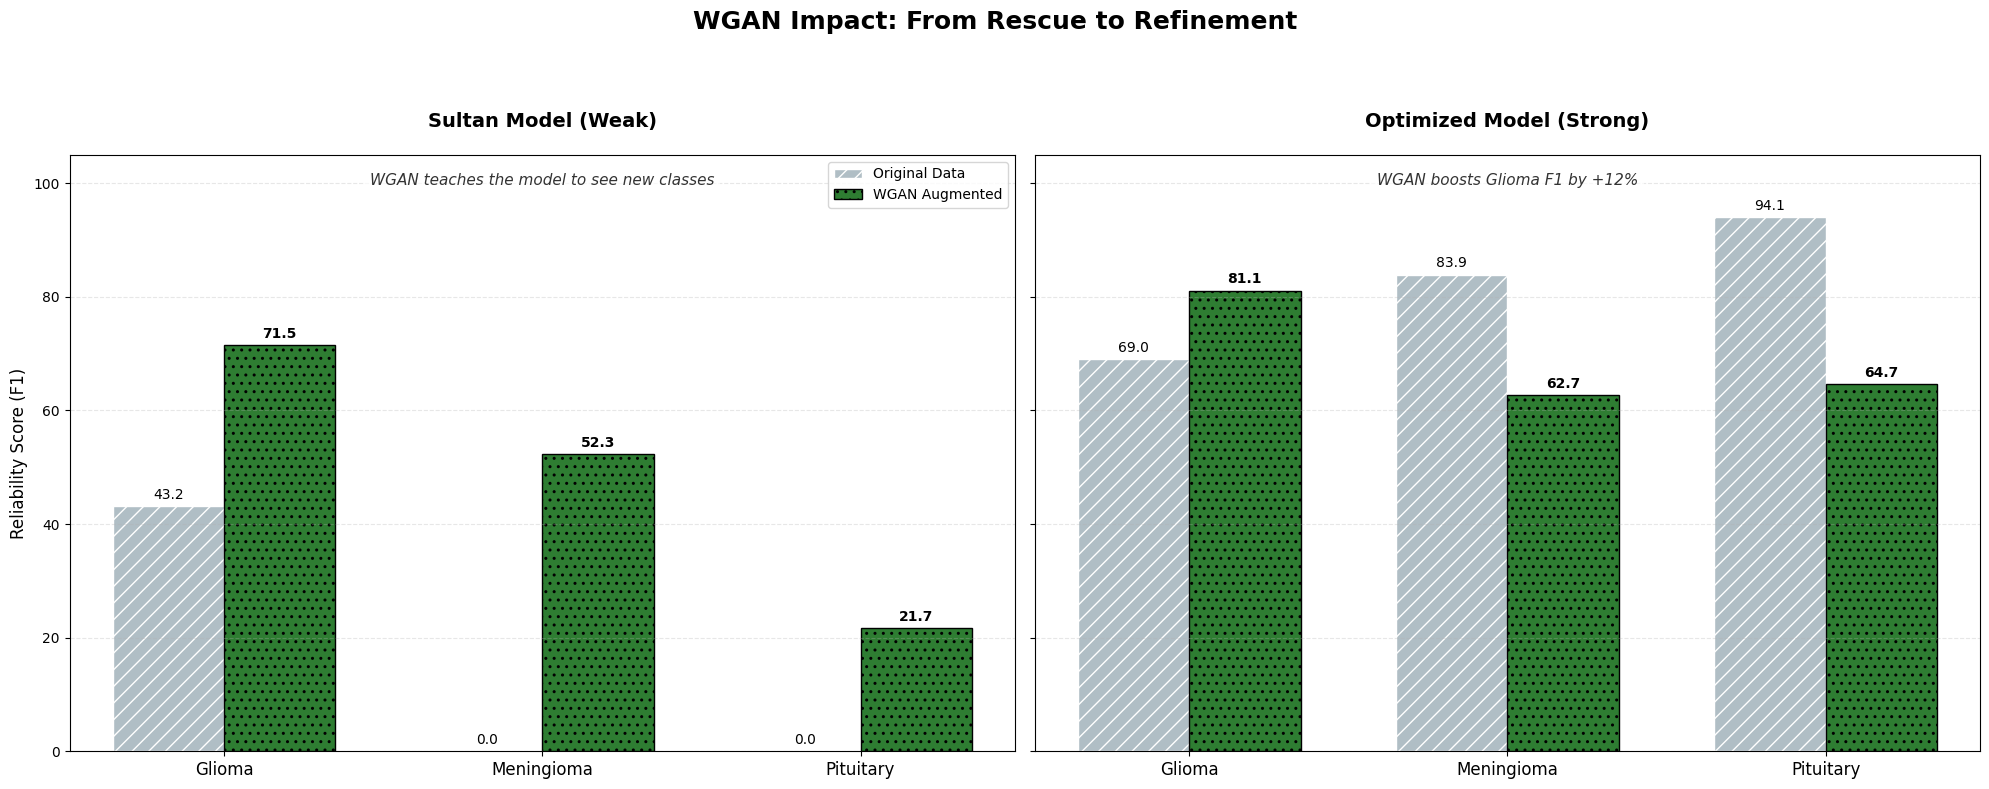

In [31]:
import matplotlib.pyplot as plt
import numpy as np


# 1. DATA (Recalculated from Latest Tables)

tumor_types = ['Glioma', 'Meningioma', 'Pituitary']

# --- A. Sultan Model (The Rescue) ---
# Original: Failed on 2 classes (0.0)
sultan_base_f1 = [43.2, 0.0, 0.0]
# WGAN: Recovered meaningful F1 scores across the board
sultan_wgan_f1 = [71.5, 52.3, 21.7]

# B. Optimized Model
# Original: Strong generalist, but Glioma F1 was 69.0%
opt_base_f1 = [69.0, 83.9, 94.1]
# WGAN: Sacrificed others to boost Glioma F1 to 81.1% (+12%)
opt_wgan_f1 = [81.1, 62.7, 64.7]


# 2. PLOT SETUP

x = np.arange(len(tumor_types))
width = 0.35

# Palette: "Before" (Grey) vs "After" (Green for Reliability)
c_base = '#B0BEC5'  # Grey
c_wgan = '#2E7D32'  # Strong Green

fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)


# 3. HELPER FUNCTION

def draw_chart(ax, data1, data2, title, highlight_text):
    rects1 = ax.bar(x - width/2, data1, width, label='Original Data', 
                    color=c_base, hatch='//', edgecolor='white')
    rects2 = ax.bar(x + width/2, data2, width, label='WGAN Augmented', 
                    color=c_wgan, hatch='..', edgecolor='black')
    
    # Styling
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(tumor_types, fontsize=12)
    ax.set_ylim(0, 105)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add values
    ax.bar_label(rects1, padding=3, fmt='%.1f', fontsize=10)
    ax.bar_label(rects2, padding=3, fmt='%.1f', fontsize=10, fontweight='bold')
    
    # Annotation Box
    ax.text(0.5, 0.95, highlight_text, transform=ax.transAxes, 
            ha='center', fontsize=11, style='italic', color='#333333',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    return rects1, rects2


# 4. DRAW PLOTS


# LEFT: Sultan (Rescue)
draw_chart(axes[0], sultan_base_f1, sultan_wgan_f1, 
           "Sultan Model (Weak)", 
           "WGAN teaches the model to see new classes")
axes[0].set_ylabel('Reliability Score (F1)', fontsize=12)
axes[0].legend(loc='upper right')

# RIGHT: Optimized (Refinement)
draw_chart(axes[1], opt_base_f1, opt_wgan_f1, 
           "Optimized Model (Strong)", 
           "WGAN boosts Glioma F1 by +12%")

# Global Title
plt.suptitle('WGAN Impact: From Rescue to Refinement', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.92]) # Leave room for title
plt.show()

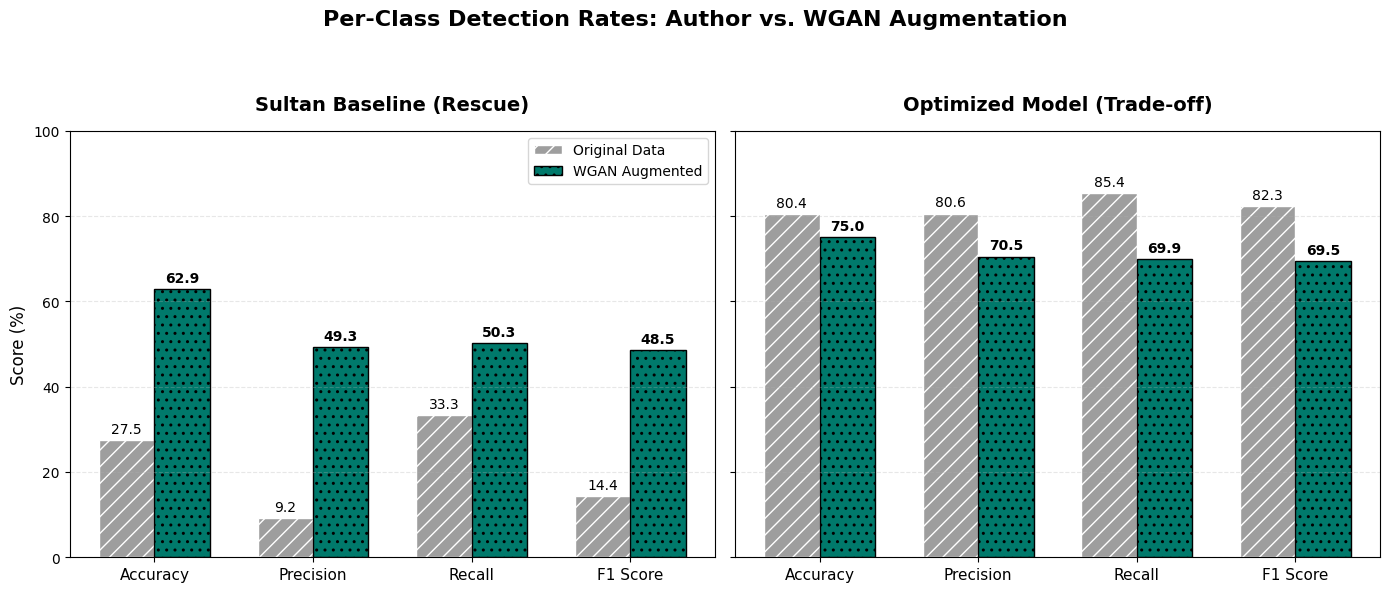

In [30]:
import matplotlib.pyplot as plt
import numpy as np


# Global Metrics (Accuracy, Precision, Recall, F1)
# Model A: Sultan Baseline (The Rescue)

sultan_original_metrics = [27.5, 9.2, 33.3, 14.4] 
sultan_wgan_metrics     = [62.9, 49.3, 50.3, 48.5]

# Model B: Optimized Model (The Trade-off)


opt_original_metrics    = [80.4, 80.6, 85.4, 82.3]
opt_wgan_metrics        = [75.0, 70.5, 69.9, 69.5]

# Per-Class Sensitivity
tumor_types = ['Glioma', 'Meningioma', 'Pituitary']

# Sultan Sensitivity
sultan_author_sens = [100.0, 0.0, 0.0]  
sultan_wgan_sens   = [74.9, 44.8, 31.3] 

# Optimized Sensitivity
# GLIOMA IS THE KEY HERE: 78.9 -> 86.6
opt_author_sens = [78.9, 77.4, 100.0]
opt_wgan_sens   = [86.6, 54.4, 68.8]


# 2. PLOT 1: The "Trade-Off" (Global Metrics)

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(labels))
width = 0.35
c_orig = '#9E9E9E'  # Grey
c_wgan = '#00796B'  # Teal

fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

def draw_global(ax, data_orig, data_wgan, title):
    rects1 = ax.bar(x - width/2, data_orig, width, label='Original Data', 
                    color=c_orig, hatch='//', edgecolor='white')
    rects2 = ax.bar(x + width/2, data_wgan, width, label='WGAN Augmented', 
                    color=c_wgan, hatch='..', edgecolor='black')
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=11)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.bar_label(rects1, padding=3, fmt='%.1f', fontsize=10)
    ax.bar_label(rects2, padding=3, fmt='%.1f', fontsize=10, fontweight='bold')
    return rects1, rects2

# Plotting
draw_global(axes1[0], sultan_original_metrics, sultan_wgan_metrics, "Sultan Baseline (Rescue)")
axes1[0].set_ylabel('Score (%)', fontsize=12)
axes1[0].legend(loc='upper right')

draw_global(axes1[1], opt_original_metrics, opt_wgan_metrics, "Optimized Model (Trade-off)")
plt.suptitle('Per-Class Detection Rates: Author vs. WGAN Augmentation', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# CROSS-CHECKING NUMBER OF IMAGES

In [18]:
import os
import pandas as pd

# Define your directory
aug_dir = './augmented_images/'
dataset_types = ['train', 'test']
classes = ['Glioma', 'Meningioma', 'Pituitary tumor']

stats = []

print(f" Auditing Image Counts in: {os.path.abspath(aug_dir)}\n")

for ds_type in dataset_types:
    for class_name in classes:
        # Construct path: ./augmented_images/train/Glioma
        folder_path = os.path.join(aug_dir, ds_type, class_name)
        
        # Count files
        if os.path.exists(folder_path):
            count = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        else:
            count = 0
            
        stats.append({
            'Subset': ds_type,
            'Class': class_name,
            'Count': count
        })

# Create a clean table
df = pd.DataFrame(stats)

# Pivot for better readability
pivot_table = df.pivot(index='Class', columns='Subset', values='Count')
pivot_table['Total'] = pivot_table['train'] + pivot_table['test']

# Display
print(pivot_table)
print("\n" + "-"*40)
print(f"Grand Total Images: {df['Count'].sum()}")

 Auditing Image Counts in: /home/stu9/s7/ss2401/AI_TERM_PROJECT/augmented_images

Subset           test  train  Total
Class                              
Glioma            198   2100   2298
Meningioma         84    885    969
Pituitary tumor    16    175    191

----------------------------------------
Grand Total Images: 3458


In [27]:
import os
import pandas as pd

# 1. Configuration
aug_dir = './data'  # Your root folder containing the 3 class subfolders
classes = ['Glioma', 'Meningioma', 'Pituitary tumor']

stats = []

print(f"Auditing Image Counts (Excluding Masks) in: {os.path.abspath(aug_dir)}\n")

# 2. Loop through each class folder
for class_name in classes:
    # Construct path: ./data/Glioma
    folder_path = os.path.join(aug_dir, class_name)
    
    # Count files
    if os.path.exists(folder_path):
        # List all files that:
        # 1. End with an image extension
        # 2. Do NOT contain the word 'mask' (case-insensitive)
        valid_images = [f for f in os.listdir(folder_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')) 
                        and 'mask' not in f.lower()] # <--- FILTER ADDED HERE
        
        count = len(valid_images)
    else:
        print(f"Warning: Folder not found -> {folder_path}")
        count = 0
        
    stats.append({
        'Class': class_name,
        'Count': count
    })

# 3. Create a clean table
df = pd.DataFrame(stats)

# 4. Display Results
print(df)
print("\n" + "-"*30)
print(f"Grand Total Images: {df['Count'].sum()}")
print("-"*30)

Auditing Image Counts (Excluding Masks) in: /home/stu9/s7/ss2401/AI_TERM_PROJECT/data

             Class  Count
0           Glioma    618
1       Meningioma    261
2  Pituitary tumor     51

------------------------------
Grand Total Images: 930
------------------------------


# Version check - for libraries

In [34]:
import sys
import tensorflow as tf
import torch
import torchvision
import numpy as np
import cv2
import sklearn
import matplotlib
import seaborn as sns
import PIL
import tqdm

# Check for tensorflow_addons (handle case where it might not be installed)
try:
    import tensorflow_addons as tfa
    tfa_version = tfa.__version__
except ImportError:
    tfa_version = "Not Installed"

print("="*30)
print("LIBRARY VERSIONS")
print("="*30)
print(f"Python:       {sys.version.split()[0]}")
print(f"TensorFlow:   {tf.__version__}")
print(f"TF Addons:    {tfa_version}")
print(f"PyTorch:      {torch.__version__}")
print(f"Torchvision:  {torchvision.__version__}")
print(f"NumPy:        {np.__version__}")
print(f"OpenCV:       {cv2.__version__}")
print(f"Scikit-Learn: {sklearn.__version__}")
print(f"Matplotlib:   {matplotlib.__version__}")
print(f"Seaborn:      {sns.__version__}")
print(f"Pillow (PIL): {PIL.__version__}")
print(f"Tqdm:         {tqdm.__version__}")
print("="*30)

# Optional: Check GPU availability for both frameworks
print("\nGPU AVAILABILITY")
print("-" * 30)
print(f"TensorFlow GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"PyTorch GPU:    {torch.cuda.is_available()}")
print("="*30)

LIBRARY VERSIONS
Python:       3.10.10
TensorFlow:   2.10.0
TF Addons:    0.19.0
PyTorch:      2.4.0+cu121
Torchvision:  0.19.0+cu121
NumPy:        1.23.5
OpenCV:       4.12.0
Scikit-Learn: 1.5.1
Matplotlib:   3.9.1
Seaborn:      0.13.2
Pillow (PIL): 11.3.0
Tqdm:         4.66.5

GPU AVAILABILITY
------------------------------
TensorFlow GPU: True
PyTorch GPU:    True


In [35]:
from IPython.display import FileLink
import shutil

# 1. Zip the folder first
folder_name = 'NameOfYourFolder' # <--- CHANGE THIS
zip_name = 'my_backup'

shutil.make_archive(zip_name, 'zip', folder_name)

# 2. Generate a clickable link
print("Click below to download:")
FileLink(f'{zip_name}.zip')

'/home/stu9/s7/ss2401/AI_TERM_PROJECT/project_download.zip'